<h1 style="text-align: center;">Tennis Analyzer ML Model V2</h1>
<h3 style="text-align: center;">Dan Warnick</h3>

<p>To start we will begin by selecting the data points we want to analyze with existing known results. For each data entry we will have two players each with the following data entries.</p>
<table style="font-size: .8em;">
    <tr>
        <th>Player Name</th>
    </tr>
</table>
<p>Along with match facts like Clay/Hard/Grass Court or Indoor/Outdoor. In the future may want to add weather and adjust certain parameters for more accuracy and more data points to train from, however for now this seems a good start.</p>

<h2>1.) Collect Data Efficiently</h2>

In [1]:
import django
from django.http import HttpResponse
from django.template import loader
import os
from django.db import models
import torch
from math import ceil, floor
import math
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from asgiref.sync import sync_to_async # type: ignore
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
import copy
import joblib
import lightgbm as lgb
# import shap
# from optuna.integration import lightgbm as lgb_optuna

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'breakpoint.settings')
# django.setup()

# from render.models import *

In [2]:
start = '20120101'
end = '20231231'
match_type = 'm'

In [3]:
start_date = datetime.strptime(start, '%Y%m%d').date()
end_date = datetime.strptime(end, '%Y%m%d').date()

RD_CUTOFF = 360

df = pd.read_csv('../../testcsvs/StephFixRP25.csv')
df['tourney_date'] = pd.to_datetime(df['tourney_date']).dt.date
df = df[(df['tourney_date'] >= start_date) & (df['tourney_date'] <= end_date)]
# df = df[(df['a_glicko_rd'] <= RD_CUTOFF) & (df['b_glicko_rd'] <= RD_CUTOFF)]

df = df.drop(['tourney_id', 'tourney_name', 'match_num', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug', 'sets', 'games', 'tiebreaks'], axis=1)
# print(df.duplicated().sum())

print(len(df))

one_hot_encoder = OneHotEncoder(sparse_output=False)

# One-Hot Encode the 'category_text' column
category_encoded = one_hot_encoder.fit_transform(df[['surface']])

# Convert to DataFrame
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder.get_feature_names_out(['surface']))

# Concatenate the one-hot encoded columns back to the original DataFrame
df = pd.concat([df.reset_index(drop=True), category_encoded_df], axis=1)

# Drop the original 'category_text' column
df.drop('surface', axis=1, inplace=True)
# print(df.duplicated().sum())

print(len(df))

31421
31421


In [4]:
category_encoded_df.head()


,surface_Clay,surface_Grass,surface_Hard
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [5]:
def trainModel(features, df_train, df_validate):
    y_train = df_train["Result"]
    y_validate = df_validate["Result"]

    X_train = df_train[features]
    X_validate = df_validate[features]

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval = lgb.Dataset(X_validate, label=y_validate, reference=lgb_train)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_freq' : 10,
        'verbosity': -1,
        'boost_from_average': True,
        'feature_pre_filter': False,
    }

    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=50,  # More iterations for better convergence
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

    # Return the trained model
    return gbm

In [6]:
def evaluateModel(model, df_test, features):
    X_test = df_test[features]
    y_test = df_test["Result"]

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

    accuracy = accuracy_score(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'auc': auc
    }

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's binary_logloss: 0.535994
Accuracy: 0.7344
AUC: 0.8085


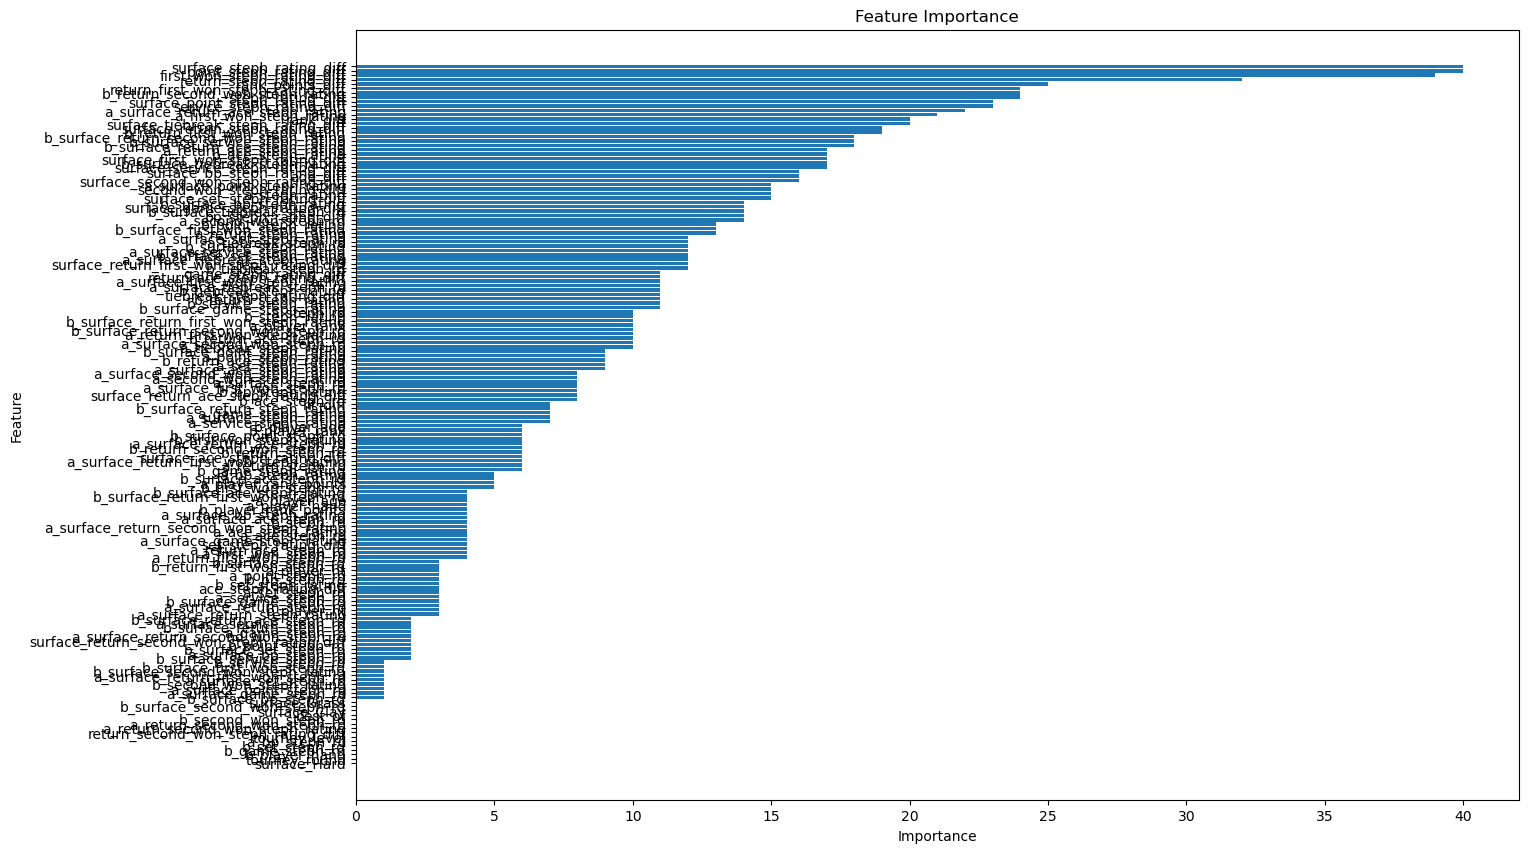

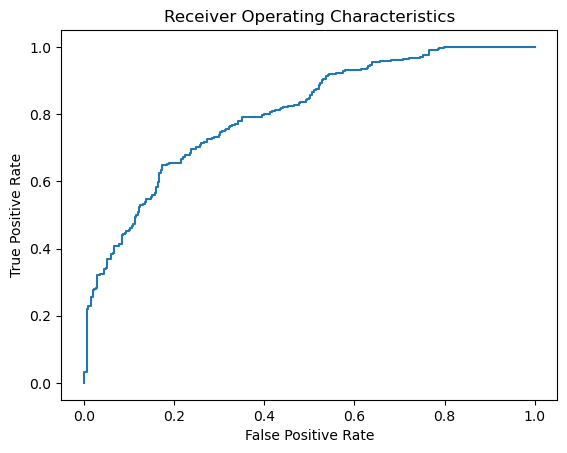

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import lightgbm as lgb

# Data cleaning and filtering
df = df.dropna()
# Uncomment and use if necessary
# df = df[(df['surface_Hard'] == 1.0)]
df = df[(df['tourney_level'] == 6)]

# Extract odds before dropping them from df
odds_df = df[['a_odds', 'b_odds']].copy()
odds_df.index = df.index  # Ensure proper indexing

df = df.drop(columns=['a_odds', 'b_odds'])  # Remove odds from feature set

# Define features and target
y = df.pop('a_b_win').values
X = df.values  # Use NumPy array for better efficiency

# Normalize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split data
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X, y, df.index, test_size=0.3, random_state=42
)

X_validate, X_test, y_validate, y_test, idx_validate, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.5, random_state=42
)

# Convert to DataFrames for model compatibility
df_train = pd.DataFrame(X_train, columns=df.columns)
df_train['Result'] = y_train

df_validate = pd.DataFrame(X_validate, columns=df.columns)
df_validate['Result'] = y_validate

df_test = pd.DataFrame(X_test, columns=df.columns)
df_test['Result'] = y_test

# Train model
selected_features = df_train.columns.drop('Result').tolist()
model = trainModel(selected_features, df_train, df_validate)

# Evaluate model
evaluation_metrics = evaluateModel(model, df_validate, selected_features)

print(f"Accuracy: {evaluation_metrics['accuracy']:.4f}")
print(f"AUC: {evaluation_metrics['auc']:.4f}")

# Feature importance
importances = model.feature_importance()
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(15, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Save model
model.save_model('lightgbm_model.txt')

# Predictions
y_pred = model.predict(X_test)

# Ensure correct odds indexing
odds_test = odds_df.loc[idx_test].values

# Create results DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'A_Odds': odds_test[:, 0],
    'B_Odds': odds_test[:, 1]
})

# Save predictions
# results_df.to_csv('predictions_with_odds.csv', index=False)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)  # Use probabilities
plt.plot(fpr, tpr)
plt.title("Receiver Operating Characteristics")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [8]:
# Display the DataFrame
# results_df.head()
print(results_df)

     Actual  Predicted  A_Odds  B_Odds
0       1.0   0.336588    2.77    1.43
1       0.0   0.217917    4.37    1.20
2       1.0   0.777866    1.15    5.25
3       1.0   0.251277    2.77    1.44
4       0.0   0.179881    5.28    1.15
..      ...        ...     ...     ...
621     1.0   0.877907    1.08    8.39
622     0.0   0.742070    1.26    3.83
623     1.0   0.174634    5.05    1.17
624     0.0   0.082317   18.36    1.01
625     1.0   0.760149    1.36    3.22

[626 rows x 4 columns]


In [9]:
# Kelly Criterion
def kelly_criterion(vegas_odds, calculated_probability):
    corrected = vegas_odds - 1
    # Calculate the Kelly fraction
    kelly_fraction = calculated_probability - ((1 - calculated_probability)/corrected)
    # Ensure that the fraction is not negative
    kelly_fraction = max(0, kelly_fraction)
    
    return kelly_fraction

In [10]:
better = 0
total_won = 0
diff_fav = 0
bet_correct = 0

upset_predict = 0
upset_correct = 0
upset_won = 0

model_correct = 0
vegas_correct = 0
vegas_total = 0

wrong = 0
comparison_df = results_df.dropna()
length = len(comparison_df)

avg_bet = 0

confidence_pct = .5
confidence_top_pct = 1

START_UNIT = 10
UNIT = START_UNIT

for i, row in comparison_df.iterrows():
    current = START_UNIT
    if confidence_top_pct > row['Predicted'] > confidence_pct :
        kelly = (kelly_criterion(row['A_Odds'], row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(row['A_Odds'], row['Predicted'])
        if(row['Actual'] == 1):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (row['A_Odds']-1) * kelly
        else:
            wrong += 1 if kelly > 0 else 0
            START_UNIT -= kelly

    if 1-confidence_top_pct < row['Predicted'] < 1-confidence_pct :
        kelly = (kelly_criterion(row['B_Odds'], 1-row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(row['B_Odds'], 1-row['Predicted'])
        if(row['Actual'] == 0):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (row['B_Odds']-1) * kelly
        else:
            wrong += 1 if kelly > 0 else 0
            START_UNIT -= kelly

    if round(row['Predicted']) != round(1/row['A_Odds']):
        kelly_A  = (kelly_criterion(row['A_Odds'],row['Predicted']) * UNIT)
        kelly_B  = (kelly_criterion(row['B_Odds'],1-row['Predicted']) * UNIT)

        upset_predict += 1 if (kelly_A > 0 and round(row['Predicted']) == 1) or (kelly_B > 0 and round(row['Predicted']) == 0) else 0

        if round(row['Predicted']) == round(row['Actual']):
            if(row['Actual'] == 1):
                upset_correct += 1 if kelly_A > 0 else 0
                upset_won += (row['A_Odds']-1) * kelly_A
            else:
                upset_correct += 1 if kelly_B > 0 else 0
                upset_won += (row['B_Odds']-1) * kelly_B
        elif round(row['Predicted']) == 1:
            upset_won -= kelly_A
        else:
            upset_won -= kelly_B
            
    if round(row['Predicted']) != round(1/row['A_Odds']):
        diff_fav += 1

    if row['Actual']==1 and row['A_Odds'] < row['B_Odds']:
        # print(f"A odds : {row['a_odds']} B odds : {row['b_odds']}")
        vegas_correct += 1

    if row['Actual']==0 and row['A_Odds'] > row['B_Odds']:
        vegas_correct += 1

    if round(row['Predicted']) == round(row['Actual']):
        model_correct += 1


print(f"Total returned on Starting ${UNIT} bankroll: {START_UNIT:.2f} on a total # bets: {better} from a total of {length} games")
print(f"ROI : {((START_UNIT-UNIT)/UNIT):.1f} X")
print(f"Avg Bankroll Bet % : {(avg_bet/better):.3f} %") if better > 0 else print("", end="")
print(f"Amount of differing favorites %: {(diff_fav/length):.3f}")
print(f"Amount of upset bets correct % : {(upset_correct/upset_predict):.3f} with Unit ${UNIT} won ${upset_won:.2f} on {upset_predict} bets")
print(f"Amount of incorrect bet % : {(wrong/better):.4f}") if better > 0 else print("", end="")
print(f"Correct Bet %: {(bet_correct/better):.4f}") if better > 0 else print("", end="")
print(f"Model % Correct : {(model_correct/length):.4f} Vegas Correct % : {(vegas_correct/length):.4f}")


Total returned on Starting $10 bankroll: 0.00 on a total # bets: 216 from a total of 626 games
ROI : -1.0 X
Avg Bankroll Bet % : 0.243 %
Amount of differing favorites %: 0.110
Amount of upset bets correct % : 0.388 with Unit $10 won $-28.99 on 67 bets
Amount of incorrect bet % : 0.4352
Correct Bet %: 0.5648
Model % Correct : 0.7220 Vegas Correct % : 0.7428
